In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import tempfile
import logging
from io import StringIO

In [3]:
#df = pd.read_csv("data/04022021.csv")
#df = pd.read_csv("data/05022021.csv")
#df = pd.read_csv("data/job_results_second_run.csv")
#df = pd.read_csv("data/job_results.csv")
#df = pd.read_csv("data/15022021.csv")
df1 = pd.read_csv("data/continuous_noise_005-02.csv")
df2 = pd.read_csv("data/continuous_noise_020-05.csv")

df = pd.concat([df1, df2], ignore_index=True)
df = pd.read_csv("data/pcalg-vs-bnlearn-continuous.csv")
#df = pd.read_csv("data/discrete.csv")
#df.columns

In [4]:
df["experiment_config/algorithm/package"]

0         pcalg
1         pcalg
2         pcalg
3         pcalg
4         pcalg
         ...   
1195    bnlearn
1196    bnlearn
1197    bnlearn
1198    bnlearn
1199    bnlearn
Name: experiment_config/algorithm/package, Length: 1200, dtype: object

In [5]:
dataset_config = [c for c in df.columns if c.startswith("config")]
gd_compare = [c for c in df.columns if c.startswith("gd_compare") and not c.endswith("edges")]
result = ['result/dataset_loading_time', 'result/execution_time', 'result/meta_results/sampling_factor']
experiment_config = ["experiment_config/parameters/alpha", "experiment_config/algorithm/function", "experiment_config/algorithm/package", "experiment_config/name"]

In [6]:
# Selecting relevant columns
columns = dataset_config + gd_compare + experiment_config + result

In [7]:
#Renaming columns
renaming_dict = {}
for c in columns:
    name_split = c.split("/")
    name = name_split[-1]
    
    if name == "rate":
        name = name_split[-2]
        
    renaming_dict[c] = name

cleaned_df = df[columns].rename(columns=renaming_dict)

In [8]:
continous_data = cleaned_df[cleaned_df.discrete_node_ratio == 0]
mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]
discrete_data = cleaned_df[cleaned_df.discrete_node_ratio == 1]

<ipython-input-8-4a95f828dd7a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]


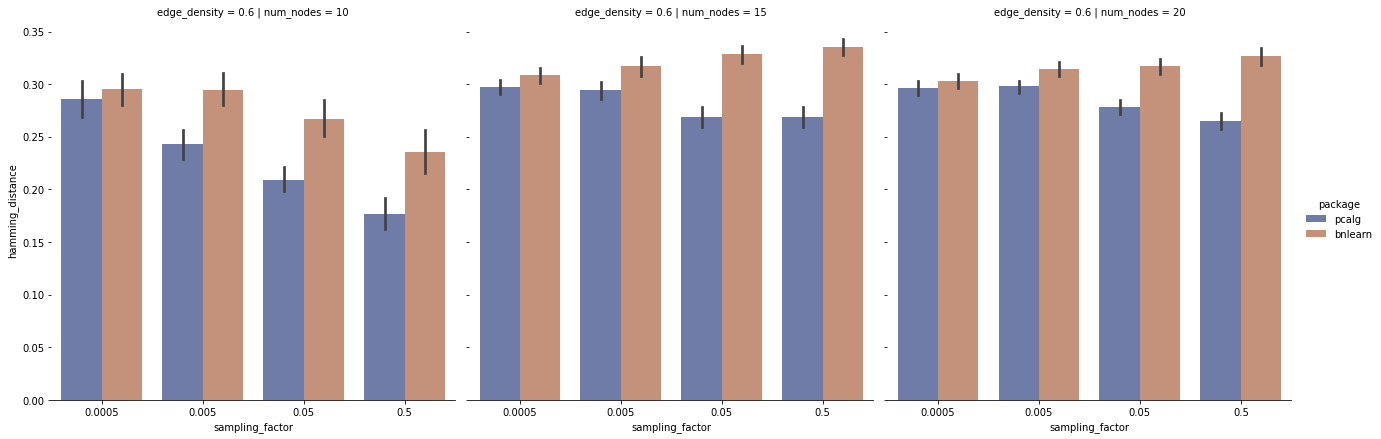

In [11]:
["num_nodes", "edge_density", "num_samples", "alpha", "discrete_node_ratio"]
metrics = ["hamming_distance"] #"graph_edit_distance", "mean_jaccard_coefficient"]
plotted_data = cleaned_df

for metric in metrics:
    
    x="sampling_factor"
    y=metric
    #hue="sampling_factor"
    hue="package"
    #hue="generator"
    row="edge_density"
    col="num_nodes"
    
    g = sns.catplot(
        data=plotted_data,
        kind="bar",
        x=x,
        y=metric,
        hue=hue,
        row=row,
        col=col,
        palette="dark",
        alpha=.6,
        height=6,
        facet_kws=dict(margin_titles=True),
    )
    #plt.title(f'Metric: {metric}, x={x}, y={y}, hue={hue}, row={row}, col={col}')
    display(g.despine(left=True))
    g.savefig("output.png")

In [10]:
plotted_data[["hamming_distance", "hamming_distance_pcdag"]][plotted_data.hamming_distance != plotted_data.hamming_distance_pcdag]

,hamming_distance,hamming_distance_pcdag
80,0.366667,0.355556
81,0.322222,0.333333
82,0.355556,0.366667
83,0.333333,0.344444
84,0.344444,0.355556
...,...,...
1195,0.342105,0.347368
1196,0.376316,0.381579
1197,NaN,NaN
1198,0.371053,0.376316


In [107]:
edge_density = 0.6
num_nodes = 5
discrete_node_ratio = 0.4

filtered_df = df[
    (df["config/edge_density"] == edge_density) &
    (df["config/num_nodes"] == num_nodes) &
    (df["config/discrete_node_ratio"] == discrete_node_ratio)
]
display(filtered_df.head()[["experiment_config/dataset"]])
network_data = df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]

,experiment_config/dataset


In [108]:
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["GET", "PUT", "DELETE", "OPTIONS"],
    backoff_factor=10
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)

In [109]:
API_HOST = "http://galileo.eaalab.hpi.uni-potsdam.de:5000"
#API_HOST = "http://localhost:5000"
API_RESULT_GRAPH = lambda result_id : f"{API_HOST}/api/result/{result_id}/export?format=GML"
API_GROUND_TRUTH_GRAPH = lambda dataset_id : f"{API_HOST}/api/dataset/{dataset_id}/ground-truth?format=GML"

def get_est_graph(result_id: int, tmp_path="./est_graph.gml"):
    response_graph = http.get(API_RESULT_GRAPH(result_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_RESULT_GRAPH(result_id)} failed."
        raise Exception(error_msg)

    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)
        
    return nx.read_gml(tmp_path)

def get_gt_graph(dataset_id: int, tmp_path="./gt-download.gml"):
    response_graph = http.get(API_GROUND_TRUTH_GRAPH(dataset_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_GROUND_TRUTH_GRAPH(dataset_id)} failed."
        logging.error(error_msg)
        raise Exception(error_msg)
        
    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)

    return nx.read_gml(tmp_path)

interactive(children=(Dropdown(description='edge_density', options=(0.6,), value=0.6), Dropdown(description='n…

<function __main__.f(edge_density: float, num_nodes: int, discrete_node_ratio: float, sampling_factor: int)>

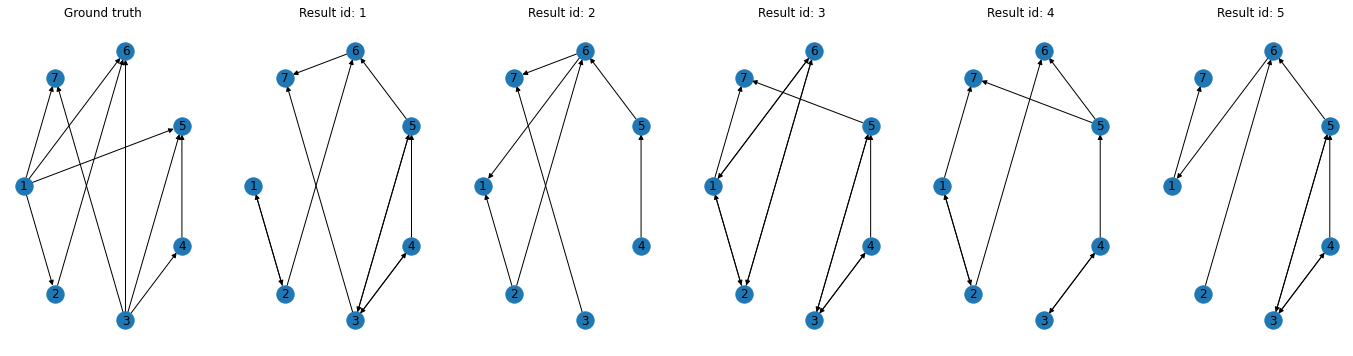

In [110]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def f(edge_density: float,
      num_nodes: int,
      discrete_node_ratio: float,
      sampling_factor: int):
    
    filtered_df = df[
        (df["config/edge_density"] == edge_density) &
        (df["config/num_nodes"] == num_nodes) &
        (df["config/discrete_node_ratio"] == discrete_node_ratio) &
        (df["result/meta_results/sampling_factor"] == sampling_factor)
    ]
    filtered_df = filtered_df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]
    display(filtered_df)

    dataset_id = filtered_df.iat[0, 2]
    print(f"dataset: {dataset_id}")
    gt_graph = get_gt_graph(dataset_id)
    
    plot_index = 161
    plt.figure(figsize=(24, 6))
    plt.subplot(plot_index)
    nx.draw_shell(gt_graph, with_labels = True)
    plt.title("Ground truth")
    #plt.show()
    
    current_plot_index = plot_index 
    #display(nx.draw_spring(gt_graph, with_labels = True))
    for i, row in filtered_df.iterrows():
        current_plot_index += 1
        result_id = int(row["result/id"])
        est_graph = get_est_graph(result_id)
        
        #print(current_plot_index)
        plt.subplot(current_plot_index)
        nx.draw_shell(est_graph, with_labels = True)
        plt.title(f"Result id: {result_id}")

    plt.show()
    #plt.figsize(15,15)
    
interact(f,
    edge_density=network_data["config/edge_density"].unique(),
    sampling_factor=network_data["result/meta_results/sampling_factor"].unique(),
    num_nodes=network_data["config/num_nodes"].unique(),
    discrete_node_ratio=network_data["config/discrete_node_ratio"].unique(),
)

In [111]:
from bokeh.io import output_notebook, reset_output, show, output_file
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from scipy.stats import norm
import seaborn as sns
from scipy.stats import pearsonr

from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral11
from bokeh.plotting import from_networkx

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from src.graph import Graph, GraphBuilder
from scipy.stats import norm
import holoviews as hv
from holoviews import opts
reset_output()
hv.extension('bokeh')
output_notebook()

ModuleNotFoundError: No module named 'src'

In [ ]:
API_DATASET_DOWNLOAD = lambda dataset_id : f'{API_HOST}/api/dataset/{dataset_id}/loadwithids'

def get_dataset(dataset_id: int):
    response_dataset = http.get(API_DATASET_DOWNLOAD(dataset_id))

    if response_dataset.status_code != 200:
        error_msg = f"API Request to {API_DATASET_DOWNLOAD(dataset_id)} failed."
        raise Exception(error_msg)
        
    return pd.read_csv(StringIO(response_dataset.text))

def is_discrete(df: pd.DataFrame, column: int):
    return df.dtypes[column] == "int64"

def create_pair_plot(df, ground_truth):

    # create three plots
    plots = []
    nodes = df.columns
    node_max = nodes[-1]
    node_min = nodes[0]

    for row_index, row in enumerate(nodes):
        for column_index, column in enumerate(nodes):

            if column_index > row_index:
                plots.append(None)
                continue

            x_axis_label = f"Node {column}" if row_index == len(nodes) - 1 else ""
            y_axis_label = f"Node {row}" if column_index == 0 else ""

            # create figure with data
            s1 = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label)

            # Check whether edge is present in groun truth
            is_edge = (row, column) in ground_truth.edges or (column, row) in ground_truth.edges

            s1.background_fill_color = "green" if is_edge else "red"
            s1.background_fill_alpha = 0.05

            x = df[column]
            y = df[row]

            if is_discrete(df, column):
                if column != row:
                    if is_discrete(df, row):
                        data = pd.DataFrame(pd.crosstab(x, y).to_numpy()).reset_index().melt('index')
                        data.columns = [f"Node {column}", f"Node {row}", "value"]
                        data.value = data.value / np.sum(data.value)
                        hm = hv.HeatMap(data)
                        hm.opts(
                            xticks=None,
                            xlabel=x_axis_label,
                            ylabel=y_axis_label,
                            cmap='Greens' if is_edge else "Reds"
                        )
                        #hm = hm * hv.Labels(hm)
                        s1 = hv.render(hm)
                    else:
                        for discrete_value in x.unique():
                            mask = x == discrete_value

                            sample_mean = np.mean(y[mask])
                            sample_std = np.std(y[mask])
                            dist = norm(sample_mean, sample_std)

                            sorted_values = sorted(y[mask])
                            probabilities = [dist.pdf(value) for value in sorted_values]

                            s1.line(sorted_values, probabilities, line_color=Spectral11[discrete_value], line_width=1, alpha=0.7, legend_label=f"{discrete_value}")
                            s1.legend.background_fill_alpha = 0.5
                else:
                    s1.background_fill_color = "white"

                    counts = x.value_counts()
                    s1.vbar(x=x.unique(), top=counts, width=0.9, fill_color="navy", line_color="white", alpha=0.5)

                    #s1.xgrid.grid_line_color = None
                    #s1.y_range.start = 0
            else:
                if column != row:
                    # Create scatter plot
                    s1.circle(x, y, size=1, alpha=0.8, color="#53777a")

                    # calculate slope + intercept
                    par = np.polyfit(x, y, 1, full=True)
                    slope=par[0][0]
                    intercept=par[0][1]
                    y_predicted = [slope*i + intercept  for i in x]
                    s1.line(x,y_predicted,color='red',legend_label=f"Corr: {round(pearsonr(x=x, y=y)[0], 4)}")
                    s1.legend.background_fill_alpha = 0.5
                else:
                    #diag plot --> histogram
                    s1.background_fill_color = "white"

                    node = row 
                    hist, edges = np.histogram(df[node], density=True, bins=50)

                    s1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
                           fill_color="navy", line_color="white", alpha=0.5)

            plots.append(s1)

    # make a grid
    grid = gridplot(plots, ncols=len(df.columns), plot_width=250, plot_height=250)

    return grid

In [ ]:
dataset_id = 22

#df = get_dataset(dataset_id)
#ground_truth = get_gt_graph(dataset_id)

In [ ]:
#grid = create_pair_plot(df, ground_truth)

#show(grid)